 # Multiclass logistic regression
 Goal:
 1. Define functions for training a multiclass logistic regression
 1. Train the classifier using gradient descent
 1. Visualize a multi-class logisitc regression for 2D data
 1. Test different feature transforms

 **Reference:**
 Section "4.3.4 Multiclass logistic regression"
 of

 C. M. Bishop *Pattern Recognition and Machine Learning*,
Information Science and Statistics, Springer, 2006

Freely available:
https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs, make_gaussian_quantiles
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Create some toy dataset:

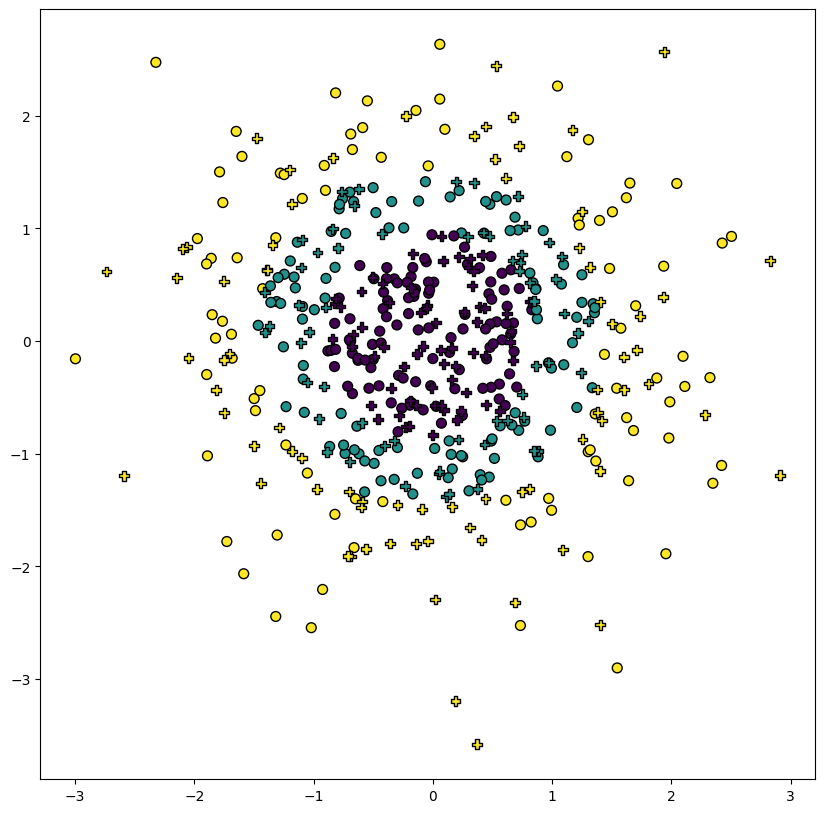

In [89]:
n_class = 3
# Three examples of synthetic 2D datasets:
X, t = make_blobs(n_features=2, centers = n_class,n_samples=100)
X, t = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=2004, n_classes=n_class, n_clusters_per_class=1,n_samples=200)
X, t = make_gaussian_quantiles(n_features=2, n_classes=n_class, n_samples=500)

X = StandardScaler().fit_transform(X)

X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=.4, random_state=12)
# Number of points in each set:
N_train = X_train.shape[0]
N_test = X_test.shape[0]

figure = plt.figure(figsize=(10, 10))
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=t_train, s=50, edgecolor='k')
plt.scatter(X_test[:, 0], X_test[:, 1], marker='P', c=t_test, s=50, edgecolor='k');
plt.show()

 <font color='blue'> **Question** : Quelle est la taille de chaque 'dataset' ? </font>

40% de tst et 60% d'entraînement



## Apply feature transform:


In [170]:

# Define some feature transforms:

def identity(x):
  return(np.hstack((x, np.ones((x.shape[0],1)))))

def feat_transform_2D_prod(x):
  return np.hstack( (x, x**2, (x[:,0]*x[:,1]).reshape((x.shape[0],1)), np.ones((x.shape[0],1))))

def feat_transform_radius(x):
  return np.hstack( ((x[:,0]**2+x[:,1]**2).reshape((x.shape[0],1)), np.ones((x.shape[0],1))))

d = 1

A = np.random.randn(2,d)
b = np.random.randn(d)

def feature_transform_Relu(x) :
  phi = x.dot(A)+b
  phi = phi*(phi> 0.)          #ReLu(phi)
  return np.hstack( (phi, np.ones((x.shape[0],1))))


feature_transform = identity
feature_transform = feat_transform_2D_prod
feature_transform = feat_transform_radius
feature_transform = feature_transform_Relu


Phi_train = feature_transform(X_train)
n_feat = Phi_train.shape[1]
print('n_feat = ', n_feat)
Phi_test = feature_transform(X_test)


n_feat =  2


<font color='blue'> **Question** Que fait le code ```np.ones((x.shape[0],1))``` ? A quoi cela correspond ? </font>

In [171]:
x = X_train[0]
print(x)
print(feature_transform(x.reshape(1,2)))

[ 1.54528431 -2.90202889]
[[1.42869559 1.        ]]


## Functions for Multiclass logistic regression:



  <font color='blue'> **Question** Observer et identifier les fonctions ci-dessous.</font>

**Reminder :**
$$
\begin{aligned}
L(\boldsymbol{W}) & = - \sum_{i=1}^N \left[w_{t_n}^T \varphi_n + \log\left(\sum_{j=1}^K \exp(w_j^T\varphi_n)\right)\right] \\
\nabla_{w_\ell} L(\boldsymbol{W}) & = \sum_{n=1}^N (y_\ell - \delta_{\ell,t_n})\varphi_n  \\
\end{aligned}
$$

In [172]:
# - W is the matrix of size n_feat x n_class

def soft_max(W, Phi):
  # evaluate the softmax vector for a list of feature points phi (given in line)
  if Phi.ndim==1: # row convention
    Phi = Phi.reshape((1,Phi.size))
  a = Phi @ W
  y = np.exp(a)
  s = np.sum(y,axis=1)
  y = y/s.reshape((s.size,1))
  return(y)

def predicted_class(W,Phi):
  if Phi.ndim==1: # row convention
    Phi = Phi.reshape((1,Phi.size))
  a = Phi @ W
  pred = np.argmax(a,axis=1)
  # # equivalent to:
  # y = soft_max(W, Phi)
  # pred = np.argmax(y,axis=1)
  return(pred)

def mloglikelihood(W, Phi, t):
  if Phi.ndim==1: # row convention
    Phi = Phi.reshape((1,Phi.size))
  y = soft_max(W, Phi)             #1
  y = y[np.arange(Phi.shape[0]),t] #2
  L = - np.sum(np.log(y))          #3
  return(L)

def gradmloglikelihood(W, Phi, t):
  if Phi.ndim==1: # row convention
    Phi = Phi.reshape((1,Phi.size))
  y = soft_max(W, Phi)                                             #A
  y[np.arange(Phi.shape[0]),t] = y[np.arange(Phi.shape[0]),t] - 1. #B
  g = Phi.transpose() @ y                                          #C
  return(g)



## Training with gradient descent on full dataset

In [173]:
# random initialization:
W = np.random.rand(n_feat,n_class)

# run Nit iterations of gradient descent (can be done several times if convergence is not observed):
Loss = []
norm_grad = []

lr = 1./N_train
Nit = 10**3
print('n = ', 0, ' L(W) = ', mloglikelihood(W, Phi_train, t_train))

Loss.append(mloglikelihood(W, Phi_train, t_train))
norm_grad.append(np.linalg.norm(gradmloglikelihood(W, Phi_train, t_train)))

for n in range(Nit):
  W -= lr*gradmloglikelihood(W, Phi_train, t_train)

  Loss.append(mloglikelihood(W, Phi_train, t_train))
  norm_grad.append(np.linalg.norm(gradmloglikelihood(W, Phi_train, t_train)))

  if n%(100)==0:
    print('n = ', n, ' L(W) = ', mloglikelihood(W, Phi_train, t_train))


n =  0  L(W) =  342.9850538715481
n =  0  L(W) =  338.12306095638894
n =  100  L(W) =  308.25248145404134
n =  200  L(W) =  304.40248853464004
n =  300  L(W) =  302.88685194290036
n =  400  L(W) =  302.11857294032984
n =  500  L(W) =  301.6781519182799
n =  600  L(W) =  301.40609558585845
n =  700  L(W) =  301.22939604481934
n =  800  L(W) =  301.11044081071503
n =  900  L(W) =  301.02818786376395


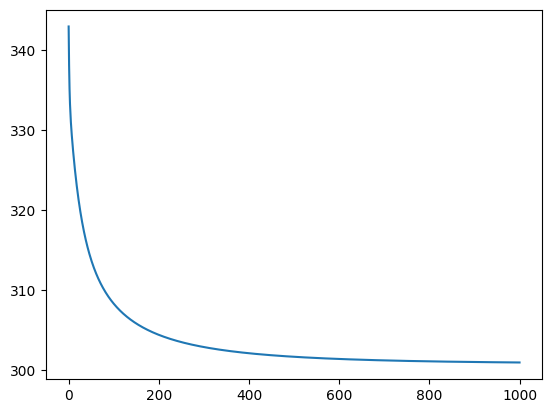

In [174]:
plt.plot(Loss)

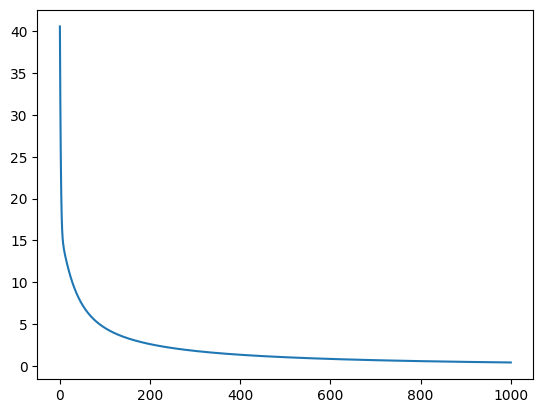

In [175]:
plt.plot(norm_grad)


  <font color='blue'>**Question** : Afficher la valeur du 'loss' et la norme du gradient au cours des itérations. </font>

 <font color='blue'>**Question** :Qu'est-ce que 'lr' ? Essayer de changer sa valeur. Commenter. </font>

## Classifier prediction:

  <font color='blue'> **Question** : Observer les probabilités prédites pour le premier point de l'ensemble de test.</font>

In [176]:
print(W.shape)
print(Phi_test.shape)

pred = predicted_class(W,Phi_test)


print('pred: ', pred[:30])
print('true: ', t_test[:30])


(2, 3)
(200, 2)
pred:  [0 0 0 0 1 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0]
true:  [2 2 2 0 0 1 1 2 1 1 0 0 1 1 2 2 2 2 1 1 2 1 1 1 2 2 0 2 0 2]


In [177]:
soft_max(W,Phi_test[0])

array([[0.4362884, 0.3338112, 0.2299004]])

## Visualize classifiction regions:


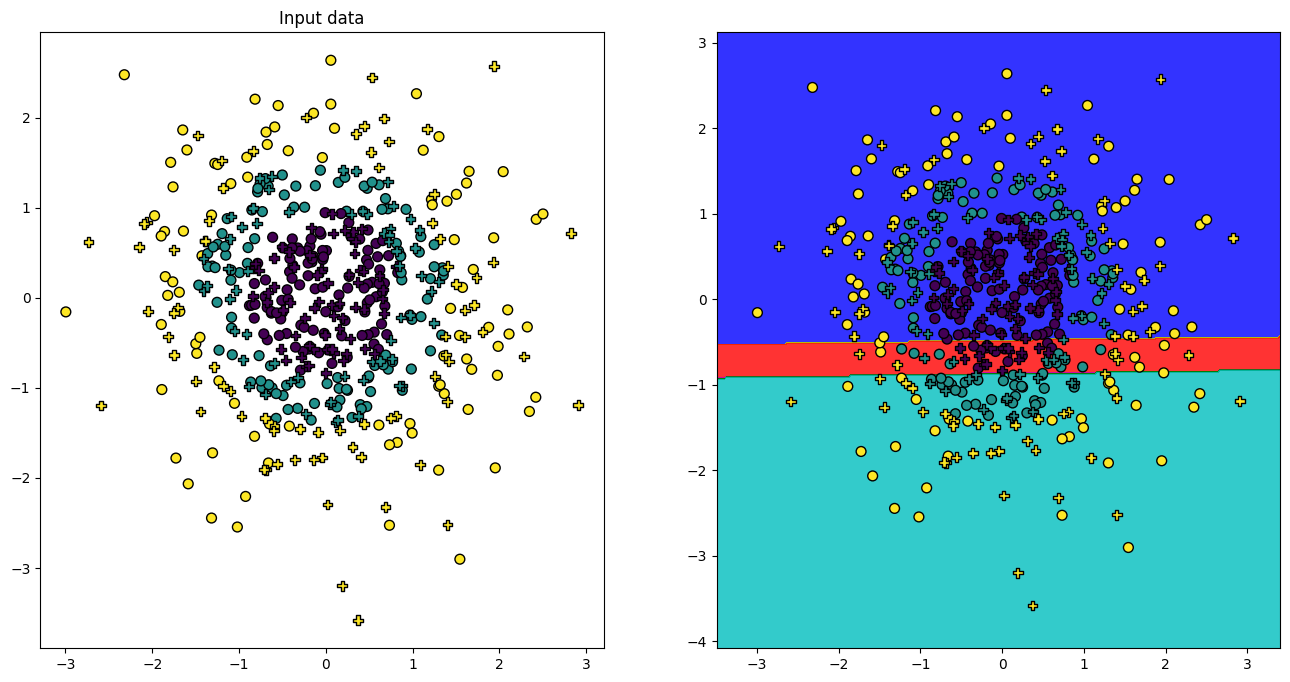

In [178]:
 #visualize results:

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
X_grid = np.hstack((xx.ravel(), yy.ravel()))

N_grid = xx.ravel().shape[0]
X_grid = np.c_[xx.ravel(), yy.ravel()]
Phi_grid = feature_transform(X_grid)

Z = predicted_class(W,Phi_grid)
Z = Z.reshape(xx.shape)

figure = plt.figure(figsize=(16, 8))
ax = plt.subplot(1,2,1)
ax.set_title("Input data")
ax.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=t_train, s=50, edgecolor='k')
ax.scatter(X_test[:, 0], X_test[:, 1], marker='P', c=t_test, s=50, edgecolor='k')
ax = plt.subplot(1,2,2)
cmap = ListedColormap(['b','y','r','m','g','c'])
plt.contourf(xx,yy,Z,  cmap = cmap, alpha=.8)
ax.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=t_train, s=50, edgecolor='k')
ax.scatter(X_test[:, 0], X_test[:, 1], marker='P', c=t_test, s=50, edgecolor='k')


## Classifier performance:
  <font color='blue'>
**Exercise**
Evaluer les performances du classifieur en utilisant les fonctions ci-dessous. (les documentations sont disponibles en ligne):</font>

```
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
```

In [168]:
from sklearn.metrics import classification_report
y_true = t_test
y_pred = predicted_class(W,Phi_test)
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.94      0.98      0.96        64
     class 1       0.98      0.93      0.96        60
     class 2       1.00      1.00      1.00        76

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



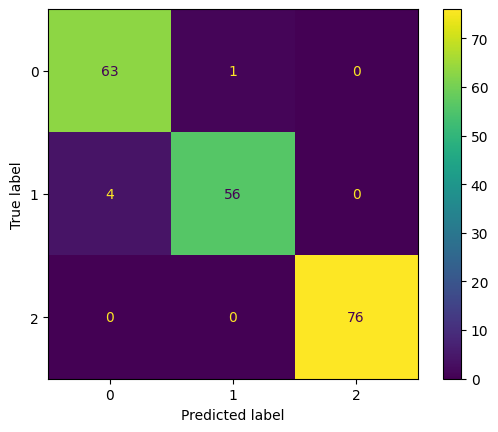

In [169]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['0','1','2'])
disp.plot()

## Importance of feature transform:

**Exercise**
With the ```gaussian_quantiles``` dataset
1. Test the classifier with the provided feature transform ```identity```. Explain the results.
2. Test the classifier with the provided feature transform ```feat_transform_2D_prod```. Explain the results.
2. Define a feature transform that would correspond to a linear hidden layer with $d=25$ hidden nodes that applies a linear+ReLU where each weight and bias parameter is drawn randomly according to a standard Gaussian distribution (iid entries, fixed and used for all data points). What can you expect for the performance of a neural network and this dataset?


  <font color='blue'> **Question**: Proposer une tranformation en "features" pour le troisième "dataset" (```gaussian_quantiles```).</font>

# Exercice pour la fois prochaine :

Envoyer un code à emile.pierret@univ-orleans.fr permettant d'obtenir la figure disponible à ce lien : https://github.com/emilePi/Apprentissage-pour-l-image/blob/main/TP/Q_Bonus.png

# S'il reste du temps :

Commener à faire connaissance avec les tensors : https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html